# 1. Подготовка

Загрузим необходимые библиотеки и функции.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

Прочтем данные.

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv')
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Перепрочтем данные. Дату сделаем индексом в формате datetime.

In [4]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Все строки заполнены значениями.  
Отсортируем данные по индексу (дате) и произведем ресемплинг по 1 часу.

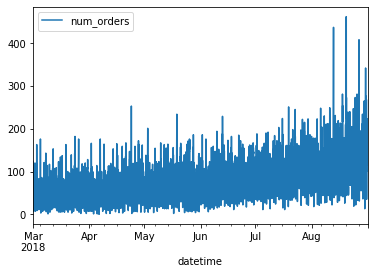

In [5]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
taxi.plot();

Посмотрим на диапазоны значений и проверим на дубликаты в индексе.

In [6]:
print('Дата: от', taxi.index.min(), 'до', taxi.index.max())
print('Кол-во заказов: от', taxi['num_orders'].min(), 'до', taxi['num_orders'].max())
print('Кол-во дубликатов в индексе:', taxi.index.duplicated().sum())

Дата: от 2018-03-01 00:00:00 до 2018-08-31 23:00:00
Кол-во заказов: от 0 до 462
Кол-во дубликатов в индексе: 0


Значения адекватны, можно работать.

# 2. Анализ

Рассмотрим тренды и сезонность заказа такси на разных промежутках времени. Для этого напишем функцию, которая принимает на вход диапазон дат и строит соответствующие графики.

In [7]:
decomposed = seasonal_decompose(taxi)

def graphics(time1, time2):
    plt.figure(figsize=(14, 5))

    plt.subplot(121)
    decomposed.trend[time1:time2].plot(ax=plt.gca(), grid=True)
    plt.title('Trend')

    plt.subplot(122)
    decomposed.seasonal[time1:time2].plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.tight_layout() 

Построим дневные графики для четырех произвольных дней.

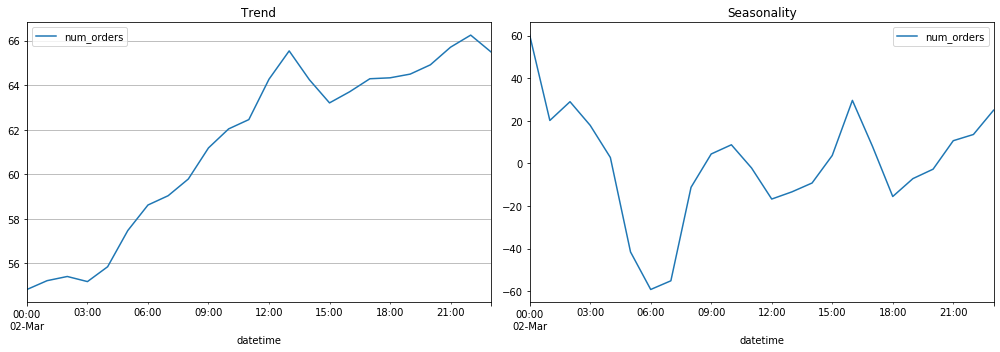

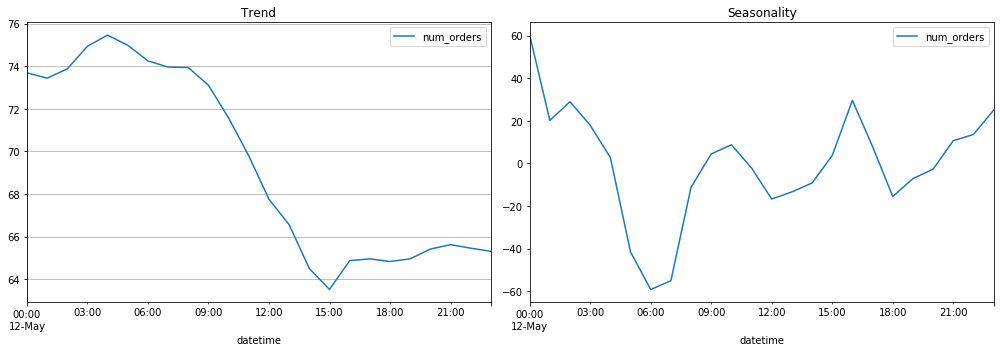

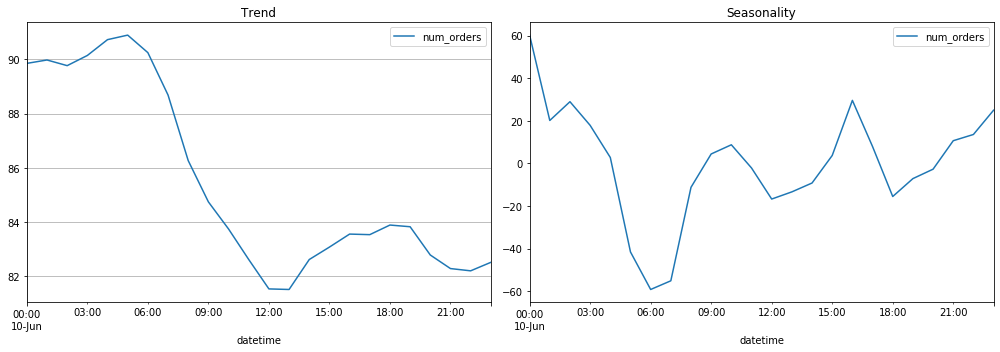

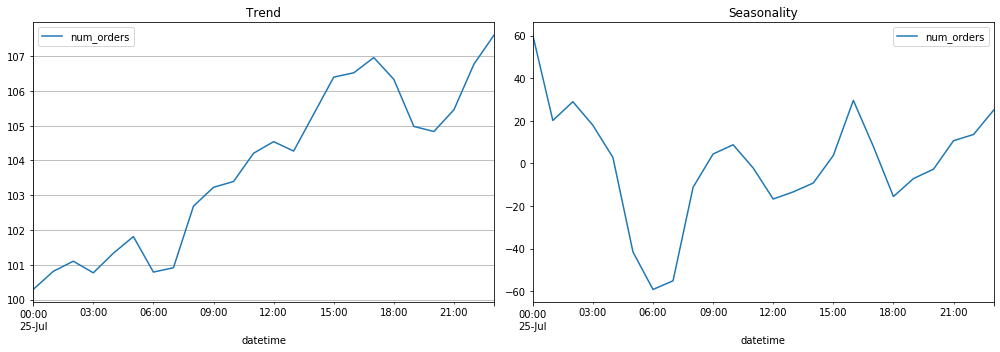

In [8]:
graphics('2018-03-02', '2018-03-02')
graphics('2018-05-12', '2018-05-12')
graphics('2018-06-10', '2018-06-10')
graphics('2018-07-25', '2018-07-25')

Сложно выделить общий тренд на дневных графиках, в двух случаях он растет, а в двух - падает. Что касается сезонности, то все четыре графика практически одинаковы: минимум в 6 утра (люди спят), максимум в полночь (возвращаются из гостей, клубов и т.п.), есть также два локальных максимума в 10 утра (едут на работу) и около 17-ти (едут с работы).  
Теперь рассмотрим недельный график.

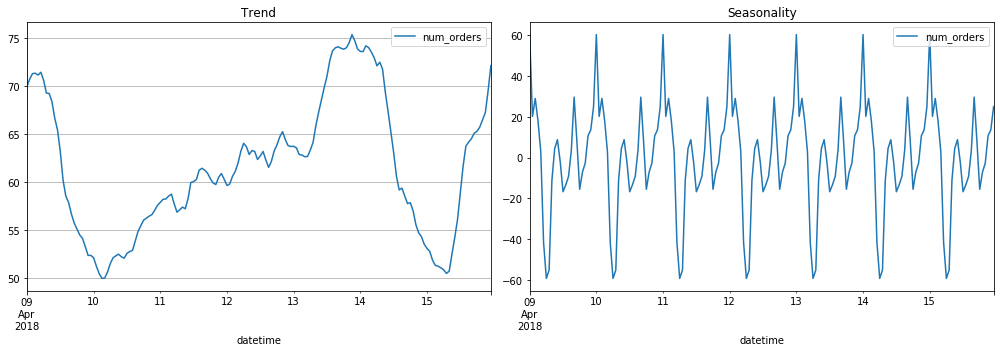

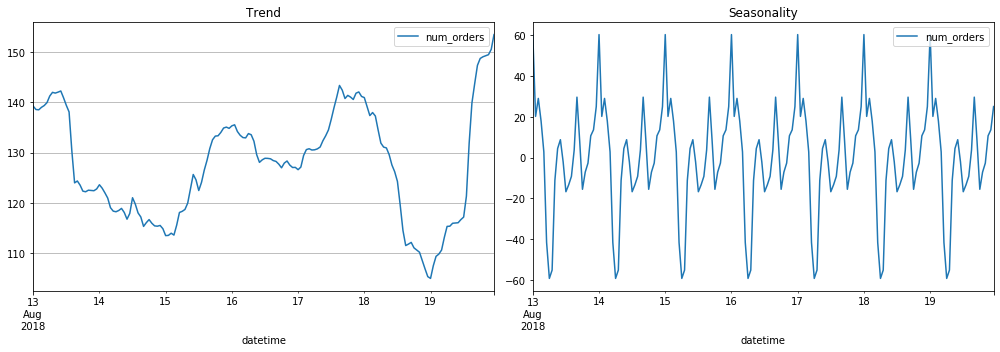

In [9]:
graphics('2018-04-09', '2018-04-15')
graphics('2018-08-13', '2018-08-19')

На графиках сезонности та же картина - минимумы в 6 утра, максимумы в нули и по 2 локальных максимума каждый день. На графиках трендов можно увидеть увеличение кол-ва заказов по пятницам и воскресеньям. ЧСХ, мы обнаруживаем сезонность на графике тренда.  
Теперь за все время.

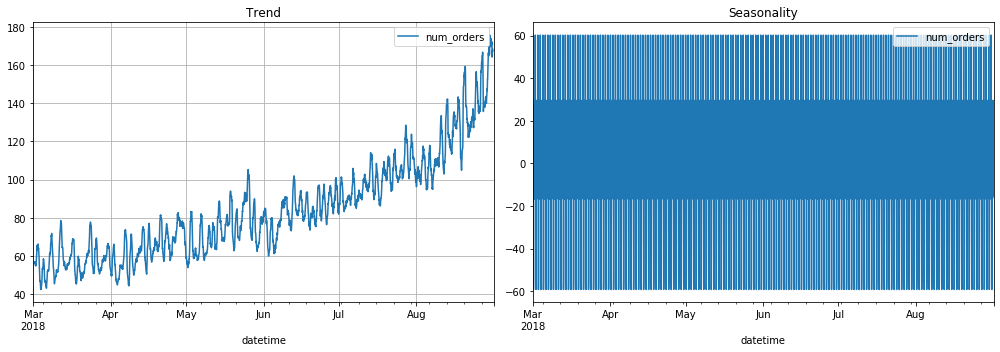

In [10]:
graphics('2018-03-01', '2018-08-31')

Если присмотреться, на графике сезонности все та же картина - дневные колебания. А вот тренд явно растет - люди все больше пользуются услугами такси.

# 3. Обучение

Добавим в таблицу признаки:  
Фактор год - совершенно точно не нужен, все данные в пределах одного года.  

Фактор месяц - непонятно, есть ли месячные колебания, данных мало, к тому значение признака '8'(август) не попадает в обучающую выборку и не используются при обучении. Убираем.  

Фактор день - не должен календарный номер дня влиять на целевой признак (если только день не праздничный, но это можно теоретически внести, как категорию, поработав с календарем). Убираем.  

Фактор день недели - однозначно оставляем, мы увидели на недельных графиках зависимость кол-ва заказов от дня недели.
Фактор час - конечно оставляем, на всех графиках сезонности есть суточная периодичность.  

Фактор lag - сделаем признаками отстающие значения за сутки, чтобы учесть рост или падение дневного тренда. Как мы видели на графиках, возможно и то и другое.  

Фактор rolling - для учета общего восходящего тренда сгладим недельные колебания, которые учтены в факторе день недели, сделаем окно шириной в неделю(7*24).  

Чтобы в скользящее среднее не попало текущее значение целевого признака применим сдвиг(shift).  
 
Начальные строки с отсутствующими значениями удалим.

In [11]:
taxi['hour'] = taxi.index.hour
taxi['day_of_week'] = taxi.index.dayofweek
    
for lag in range(1, 24+1):
    taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(7*24).mean()

taxi = taxi.dropna()
taxi

,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,54.226190
2018-03-08 01:00:00,78,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.339286
2018-03-08 02:00:00,65,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.261905
2018-03-08 04:00:00,60,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.273810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,154.297619
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,154.434524
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,154.285714


Разделим выборку на обучающую, валидационную и тестовую. Так как наш изначальный ряд значений временной, будем сохранять временнУю последовательность (shuffle=False).

In [12]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train, valid = train_test_split(train, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
features_valid = valid.drop('num_orders', axis=1)
features_test = test.drop('num_orders',axis=1)

target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

Обучим модель линейной регрессии.

In [13]:
model = LinearRegression()
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
print('RMSE =', mean_squared_error(target_valid, prediction)**0.5)

RMSE = 35.107080717510605


Перейдем к случайному лесу и подберем гиперпараметры.

In [14]:
rmse_min = 100
for estim in range(1, 20, 1):
    for depth in range(1, 16, 1):
        model = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, prediction)**0.5
        if rmse < rmse_min:
            rmse_min = rmse
            est = estim
            dep = depth
print('Наименьшее значение RMSE =', rmse_min, 'при:')
print('n_estimators =', est)
print('max_depth =', dep)

Наименьшее значение RMSE = 32.50059937725961 при:
n_estimators = 18
max_depth = 14


Запустим модель градиентного бустинга от Microsoft также с перебором гиперпараметров (при тестировании диапазоны были шире).

In [15]:
rmse_min = 100
lr = 0.1
while lr <= 0.4:
    for depth in range(1, 10, 1):
        model = lgb.LGBMRegressor(
                     learning_rate = lr, 
                     max_depth = depth,
                     metric = 'rmse',
                     random_state = 12345, 
                     n_estimators = 200
                                        )

        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, prediction)**0.5
        if rmse < rmse_min:
            rmse_min = rmse
            l_r = lr
            dep = depth
    lr += 0.1
    
print('Наименьшее значение RMSE =', rmse_min, 'при:')
print('learning_rate =', l_r)
print('max_depth =', dep)

Наименьшее значение RMSE = 30.768458847273948 при:
learning_rate = 0.1
max_depth = 4


# 4. Тестирование

Для оценки адекватности моделей сделаем предсказание предыдущим значением ряда. Для первого значения предыдущее - это последнее значение валидационной выборки.

In [16]:
prediction = target_test.shift()
prediction.iloc[0] = target_valid.iloc[-1]
print('Оценочная RMSE = ', mean_squared_error(target_test, prediction)**0.5)

Оценочная RMSE =  58.819724582830204


Напишем функцию, строящую графики предсказания и истинного значения в интервале 4 дня с 14 по 17 августа.

In [17]:
plt.rcParams['figure.figsize'] = [16, 8]

def twin_graph():
    first = pd.DataFrame(prediction, index=target_test.index)['2018-08-14':'2018-08-17']
    second = target_test['2018-08-14':'2018-08-17']
    fig, ax = plt.subplots()
    ax.plot(first, label='предсказание', linewidth = 3)
    ax.plot(second, label='значение', linewidth = 3)
    ax.minorticks_on()
    ax.grid(
        which='major',
        color = 'k', 
        linewidth = 1)
    ax.grid(
        which='minor', 
        color = 'k', 
        linestyle = ':', 
        linewidth = 0.1  
          )
    ax.legend()

Проверим на тестовой выборке модель линейной регрессии.

Для линейной регрессии RMSE = 44.636164214702156


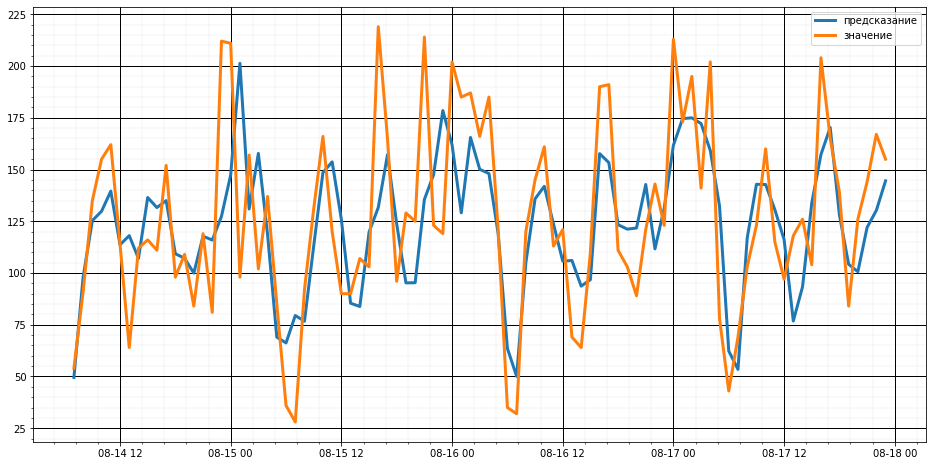

In [18]:
model = LinearRegression()
model.fit(features_train, target_train)
prediction = model.predict(features_test)
print('Для линейной регрессии RMSE =', mean_squared_error(target_test, prediction)**0.5)
twin_graph()

Теперь проверим случайный лес с лучшими гиперпараметрами.

Для случайного леса RMSE = 46.5670034387561


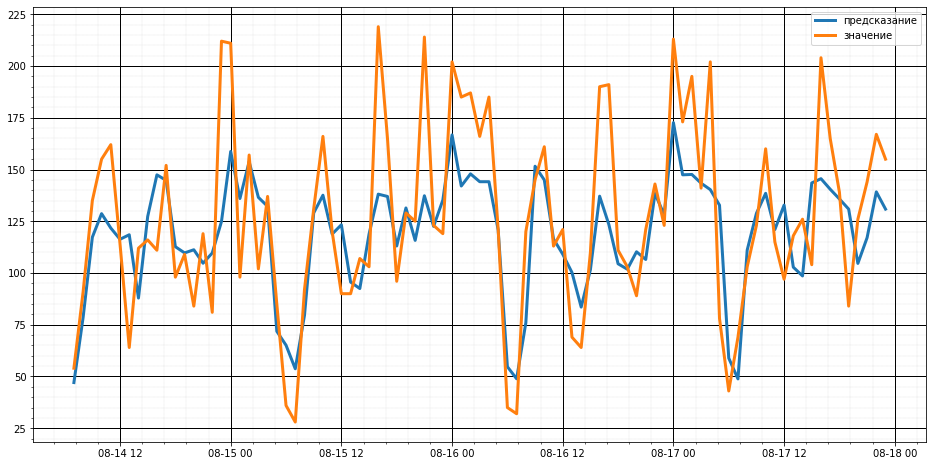

In [19]:
model = RandomForestRegressor(
    n_estimators=18, 
    max_depth=14, 
    random_state=12345
)
model.fit(features_train, target_train)
prediction = model.predict(features_test)
print('Для случайного леса RMSE =', mean_squared_error(target_test, prediction)**0.5)
twin_graph()

И, наконец, градиентный бустинг.

Для градиентного бустинга RMSE = 47.96796311680296


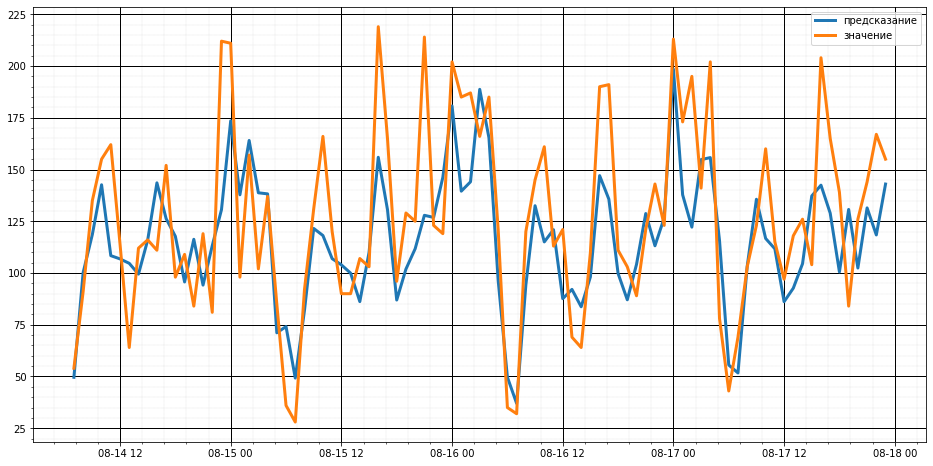

In [20]:
model = lgb.LGBMRegressor(
        learning_rate = 0.1, 
        max_depth = 4,
        metric = 'rmse',
        random_state = 12345, 
        n_estimators = 200
                           )

model.fit(features_train, target_train,
          eval_metric= 'rmse',
#         eval_set = [(features_test, target_test)], 
#         early_stopping_rounds = 5, 
#         verbose = 10
                            )

prediction = model.predict(features_test)
print('Для градиентного бустинга RMSE =',  mean_squared_error(target_test, prediction)**0.5)
twin_graph()

Итак, все модели опередили оценочную и уложились в заданные рамки метрики (RMSE<48).  
Для линейной регрессии RMSE = 44.64  
Для случайного леса RMSE = 46.57  
Для градиентного бустинга RMSE = 47.97  
Это, кстати, первый раз, когда у меня впереди всех регрессия. На графиках видно, что у всех моделей отставание по амплитуде, особенно на максимумах. Наименьшее отставание показывает регрессия, видимо, отсюда и лучший скор. Но!!!  
У линейной регрессии наблюдается отставание по фазе, что для горизонта планирования в 1 час критично. В этом плане две другие модели выглядят получше, а недостаток амплитуды можно скорректировать, выпустив на линию такси с небольшим запасом.